# import llibraries

In [1]:
import pandas as pd
import joblib as jl
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from dash import Dash, html, dcc, Input, Output

# Reading the Data


In [2]:
data = pd.read_csv('US_Regional_Sales_Data.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7991 entries, 0 to 7990
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   OrderNumber       7991 non-null   object 
 1   Sales Channel     7991 non-null   object 
 2   WarehouseCode     7991 non-null   object 
 3   ProcuredDate      7991 non-null   object 
 4   OrderDate         7991 non-null   object 
 5   ShipDate          7991 non-null   object 
 6   DeliveryDate      7991 non-null   object 
 7   CurrencyCode      7991 non-null   object 
 8   _SalesTeamID      7991 non-null   int64  
 9   _CustomerID       7991 non-null   int64  
 10  _StoreID          7991 non-null   int64  
 11  _ProductID        7991 non-null   int64  
 12  Order Quantity    7991 non-null   int64  
 13  Discount Applied  7991 non-null   float64
 14  Unit Cost         7991 non-null   object 
 15  Unit Price        7991 non-null   object 
dtypes: float64(1), int64(5), object(10)
memory

# Check about the nulls

In [4]:
data.isnull().sum()

OrderNumber         0
Sales Channel       0
WarehouseCode       0
ProcuredDate        0
OrderDate           0
ShipDate            0
DeliveryDate        0
CurrencyCode        0
_SalesTeamID        0
_CustomerID         0
_StoreID            0
_ProductID          0
Order Quantity      0
Discount Applied    0
Unit Cost           0
Unit Price          0
dtype: int64

# Drop the Duplicates

In [5]:
data.drop_duplicates(inplace=True)

# Feature

The code removes commas from the 'Unit Cost' and 'Unit Price' columns to prepare the data for numeric conversion. This is necessary because commas (used as thousand separators) prevent the values from being interpreted as numbers.


In [6]:
data['Unit Cost'] = data['Unit Cost'].str.replace(',','')
data['Unit Price'] = data['Unit Price'].str.replace(',','')

## This code converts specific columns in the DataFrame to appropriate data types for analysis:


In [7]:
data['Unit Cost'] = pd.to_numeric(data['Unit Cost'], errors='coerce')
data['Unit Price'] = pd.to_numeric(data['Unit Price'], errors='coerce')
data['ProcuredDate'] = pd.to_datetime(data['ProcuredDate'])
data['OrderDate'] = pd.to_datetime(data['OrderDate'])
data['ShipDate'] = pd.to_datetime(data['ShipDate'])
data['DeliveryDate'] = pd.to_datetime(data['DeliveryDate'])

C:\Users\yasse\AppData\Local\Temp\ipykernel_7952\900529364.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['ProcuredDate'] = pd.to_datetime(data['ProcuredDate'])
C:\Users\yasse\AppData\Local\Temp\ipykernel_7952\900529364.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['OrderDate'] = pd.to_datetime(data['OrderDate'])
C:\Users\yasse\AppData\Local\Temp\ipykernel_7952\900529364.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['ShipDate'] = pd.to_datetime(data['ShipDate'])
C:\Users\yasse\AppData\Local\Temp\ipykernel_7952\900529364.py:6: UserWarning: Cou

## This code extracts date components from the 'OrderDate' column to facilitate time-based analysis:

OrderYear, OrderMonth, OrderDay: Extract the year, month, and day from each order date.

OrderDayOfWeek: Returns the day of the week as an integer (Monday = 0, Sunday = 6), useful for analyzing weekly patterns in orders.

In [8]:
data['OrderYear'] = data['OrderDate'].dt.year
data['OrderMonth'] = data['OrderDate'].dt.month
data['OrderDay'] = data['OrderDate'].dt.day
data['OrderDayOfWeek'] = pd.to_datetime(data['OrderDate']).dt.dayofweek

# feature engineering

 `IsWeekend`  is a new feature that indicates whether the order was placed on a weekend. It checks if the value in `OrderDayOfWeek` is 5 (Saturday) or 6 (Sunday), returning `1` for weekend and `0` for weekdays.

 
 `OrderWeek` is a new column  converte the `OrderDate` column to datetime format and extracte the ISO calendar week number (1–52/53) for each order.


In [9]:
data['IsWeekend'] = data['OrderDayOfWeek'].isin([5, 6]).astype(int)
data['OrderWeek'] = pd.to_datetime(data['OrderDate']).dt.isocalendar().week

  `Rolling_Avg_7`
  This feature calculates a 7-day centered rolling average of the `Unit Price` column  . Centering ensures that the average is aligned with the middle of the 7-day window.
  
  `Rolling_Avg_30`
  This feature calculates a 30-day centered rolling average of the `Unit Price` column, smoothing out long-term trends in pricing over a wider time window.


In [10]:
data['Rolling_Avg_7'] = data['Unit Price'].rolling(window=7,center=True).mean().fillna(0)
data['Rolling_Avg_30'] = data['Unit Price'].rolling(window=30,center=True).mean().fillna(0)

  `Lag_1`
  This feature Creates a new column that contains the `Unit Price` from the previous row, effectively introducing a 1-day lag.

  `Lag_2`  
  Adds another column with values from two days before, introducing a 2-day lag.

  `Lag_6`  
  Creates a column containing the `Unit Price` from six days earlier.  

These lag features can be useful for time series analysis or predictive modeling.


In [11]:
data['Lag_1'] = data['Unit Price'].shift(1).fillna(0)
data['Lag_2'] = data['Unit Price'].shift(2).fillna(0)
data['Lag_6'] = data['Unit Price'].shift(6).fillna(0)

# outliers

## This function detects outliers in a specified DataFrame column using the **Interquartile Range (IQR)** method:

Explanation:
Q1: 25th percentile (lower quartile)

Q3: 75th percentile (upper quartile)

IQR: Range between Q3 and Q1

Outliers: Any value below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR

In [12]:
def detect_outliers(df, column):
    """Detects outliers in a DataFrame column using the IQR method.

    Args:
        df (pd.DataFrame): The DataFrame.
        column (str): The column name to check for outliers.

    Returns:
        pd.Series: A boolean series where True indicates an outlier.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return (df[column] < lower_bound) | (df[column] > upper_bound)

## This function counts the number of outliers in each **numeric column** of a DataFrame using the IQR method and returns a sorted dictionary:

select_dtypes(include=['number']): Selects only numeric columns.

detect_outliers(df, col).sum(): Counts True values (i.e., outliers) in each column.

Sorting: Columns are sorted in descending order based on the number of outliers.

The result is a dictionary where keys are column names and values are the number of detected outliers, sorted from most to least.

In [13]:
def count_outliers(df):
    """Counts outliers in each numerical column and sorts in descending order."""
    numeric_columns = df.select_dtypes(include=['number']).columns
    outlier_counts = {col: detect_outliers(df, col).sum() for col in numeric_columns}

    sorted_outlier_counts = dict(sorted(outlier_counts.items(), key=lambda x: x[1], reverse=True))

    return sorted_outlier_counts

## This function **iteratively removes outliers** from a DataFrame until the total number of outliers is less than or equal to a given threshold:

Key Points:
Works only on numeric columns.

Uses IQR method to identify and remove outliers.

Iterates until the number of outliers is less than or equal to threshold (default is 0).

reset_index(drop=True) ensures clean indexing after row removal.

In [14]:
def remove_outliers_iteratively(data, threshold=0):
    """Removes outliers iteratively until no new outliers are found.

    Args:
        df (pd.DataFrame): The DataFrame.
        threshold (int): Minimum number of outliers to stop removal early.

    Returns:
        pd.DataFrame: Cleaned DataFrame.
    """
    data_cleaned = data.copy()
    numeric_columns = data.select_dtypes(include=['number']).columns

    while True:
        outlier_counts = count_outliers(data_cleaned)
        total_outliers = sum(outlier_counts.values())

        if total_outliers <= threshold:
            break

        for column in numeric_columns:
            data_cleaned = data_cleaned[~detect_outliers(data_cleaned, column)]

        data_cleaned = data_cleaned.reset_index(drop=True)

    return data_cleaned

## This code computes the number of outliers in each numeric column of the `data` DataFrame:

Calls the count_outliers() function to count outliers using the IQR method.

The result is a dictionary showing how many outliers were found in each numeric column.

Useful for identifying which features have the most extreme values and may need cleaning or transformation.

In [15]:
outlier_counts = count_outliers(data)
outlier_counts

{'Discount Applied': np.int64(346),
 'Unit Cost': np.int64(247),
 'Rolling_Avg_7': np.int64(108),
 'Rolling_Avg_30': np.int64(85),
 '_SalesTeamID': np.int64(0),
 '_CustomerID': np.int64(0),
 '_StoreID': np.int64(0),
 '_ProductID': np.int64(0),
 'Order Quantity': np.int64(0),
 'Unit Price': np.int64(0),
 'OrderYear': np.int64(0),
 'OrderMonth': np.int64(0),
 'OrderDay': np.int64(0),
 'OrderDayOfWeek': np.int64(0),
 'IsWeekend': np.int64(0),
 'OrderWeek': np.int64(0),
 'Lag_1': np.int64(0),
 'Lag_2': np.int64(0),
 'Lag_6': np.int64(0)}

## This line removes outliers from the `data` DataFrame using the `remove_outliers_iteratively` function:

When uncommented, it will clean the dataset by removing outliers from all numeric columns.

It does so iteratively, ensuring no further outliers remain (or until a defined threshold is met).

Commenting it out allows for testing or running the code without immediately altering the dataset.

In [16]:
# data = remove_outliers_iteratively(data)

## This code computes the number of outliers in each numeric column of the `data` DataFrame:

Calls the count_outliers() function to count outliers using the IQR method.

The result is a dictionary showing how many outliers were found in each numeric column.

Useful for identifying which features have the most extreme values and may need cleaning or transformation.

In [17]:
outlier_counts = count_outliers(data)
outlier_counts

{'Discount Applied': np.int64(346),
 'Unit Cost': np.int64(247),
 'Rolling_Avg_7': np.int64(108),
 'Rolling_Avg_30': np.int64(85),
 '_SalesTeamID': np.int64(0),
 '_CustomerID': np.int64(0),
 '_StoreID': np.int64(0),
 '_ProductID': np.int64(0),
 'Order Quantity': np.int64(0),
 'Unit Price': np.int64(0),
 'OrderYear': np.int64(0),
 'OrderMonth': np.int64(0),
 'OrderDay': np.int64(0),
 'OrderDayOfWeek': np.int64(0),
 'IsWeekend': np.int64(0),
 'OrderWeek': np.int64(0),
 'Lag_1': np.int64(0),
 'Lag_2': np.int64(0),
 'Lag_6': np.int64(0)}

# ADF

  Sets the `OrderDate` column as the DataFrame index, which is useful for time series analysis and enables date-based operations.

  Sorts the DataFrame by the new datetime index in ascending order to ensure chronological alignment of the data.


In [18]:
data.set_index('OrderDate', inplace=True)

data.sort_index(inplace=True) 

### Augmented Dickey-Fuller (ADF) Test Function

This function checks whether a time series is **stationary**, which is important for many time series models (like ARIMA).

-   Defines a function that takes a pandas Series and its column name as input.

-   Runs the Augmented Dickey-Fuller test from `statsmodels` to test for stationarity.

-   Prints the ADF test statistic.

-   Prints the p-value associated with the test.

- The conditional check:
  - If `p-value <= 0.1`: Rejects the null hypothesis — the series is likely **stationary**.
  - Otherwise: Fails to reject the null — the series is **not stationary**.


In [19]:
def adf_test(series, column_name):
    result = adfuller(series)
    print(f'ADF Statistic for {column_name}: {result[0]}')
    print(f'p-value: {result[1]}')
    
    if result[1] <= 0.1:
        print(f"{column_name} is stationary (reject null hypothesis)")
    else:
        print(f"{column_name} is NOT stationary (fail to reject null hypothesis)")


### ADF Test on `Unit Price`

We applied the Augmented Dickey-Fuller (ADF) test to the `Unit Price` column to assess its stationarity — a key assumption in many time series models.


In [20]:
adf_test(data['Unit Price'], 'Unit Price')

ADF Statistic for Unit Price: -51.96975139431462
p-value: 0.0
Unit Price is stationary (reject null hypothesis)


### Interactive Sales Dashboard with Dash

This Dash app visualizes key metrics and trends from regional sales data. The dashboard includes:

#### 🔢 KPIs (Top Metrics)
- **Total Orders**: Total number of transactions.
- **Average Unit Price**: Mean selling price across all orders.
- **Total Revenue**: Calculated as `Order Quantity × Unit Price`.
- **Sales Channels**: Number of unique sales channels.
- **Max Discount**: Highest discount applied on any order.

#### 🎛️ Interactive Filter
- A **discount slider** filters the histogram by maximum discount allowed.

#### 📊 Visualizations
1. **Price Distribution Histogram** (filtered by discount threshold).
2. **Box Plot** of Unit Price by Sales Channel.
3. **Time Series Line Chart** showing price trends over time.
4. **Stacked Bar Chart** illustrating price vs. quantity by channel.
5. **Pie Chart** of Sales Channel distribution.

#### 🔁 Callback
- The histogram dynamically updates based on the discount slider input.

This setup offers a user-friendly way to explore trends, compare channels, and monitor pricing dynamics.


In [21]:
app = Dash(__name__)

# ==== KPIs ====
total_orders = len(data)
avg_price = round(data['Unit Price'].mean(), 2)
total_revenue = round((data['Order Quantity'] * data['Unit Price']).sum(), 2)
num_channels = data['Sales Channel'].nunique()
max_discount = round(data['Discount Applied'].max(), 2)

# ==== Sliders & Figures ====
discount_slider = dcc.Slider(
    0, 0.4, step=0.05,
    value=0.1,
    id='discount-slider'
)
price_histogram = dcc.Graph(id='price-histogram')

box_fig = px.box(data, x='Sales Channel', y='Unit Price', 
                 title="Price vs. Sales Channel Box Plot")
box_plot = dcc.Graph(figure=box_fig)

time_df = data.groupby('OrderDate')['Unit Price'].mean().reset_index()
line_fig = px.line(time_df, x='OrderDate', y='Unit Price',
                   title="Time Series Price Analysis")
line_chart = dcc.Graph(figure=line_fig)

bar_fig = px.bar(data, x='Order Quantity', y='Unit Price',
                 color='Sales Channel',
                 title="Price-Quantity Relationship Scatter Plot")
bar_fig.update_layout(barmode='stack')
stacked_bar = dcc.Graph(figure=bar_fig)

pie_data = data['Sales Channel'].value_counts().reset_index()
pie_data.columns = ['Sales Channel', 'Count']
pie_fig = px.pie(pie_data, names='Sales Channel', values='Count',
                 title='Sales Channel Distribution')
pie_chart = dcc.Graph(figure=pie_fig)

# ==== Layout ====
app.layout = html.Div([

    # ==== KPI Cards ====
    html.Div([
        html.Div([
            html.H4("Total Orders"),
            html.H3(f"{total_orders}")
        ], style={'width': '18%', 'display': 'inline-block', 'padding': '10px',
                  'backgroundColor': '#f9f9f9', 'margin': '5px', 'textAlign': 'center', 'boxShadow': '2px 2px 5px lightgray'}),

        html.Div([
            html.H4("Avg. Unit Price"),
            html.H3(f"${avg_price}")
        ], style={'width': '18%', 'display': 'inline-block', 'padding': '10px',
                  'backgroundColor': '#f9f9f9', 'margin': '5px', 'textAlign': 'center', 'boxShadow': '2px 2px 5px lightgray'}),

        html.Div([
            html.H4("Total Revenue"),
            html.H3(f"${total_revenue/1000000:0.2f} M")
        ], style={'width': '18%', 'display': 'inline-block', 'padding': '10px',
                  'backgroundColor': '#f9f9f9', 'margin': '5px', 'textAlign': 'center', 'boxShadow': '2px 2px 5px lightgray'}),

        html.Div([
            html.H4("Sales Channels"),
            html.H3(f"{num_channels}")
        ], style={'width': '18%', 'display': 'inline-block', 'padding': '10px',
                  'backgroundColor': '#f9f9f9', 'margin': '5px', 'textAlign': 'center', 'boxShadow': '2px 2px 5px lightgray'}),

        html.Div([
            html.H4("Max Discount"),
            html.H3(f"{max_discount * 100}%")
        ], style={'width': '18%', 'display': 'inline-block', 'padding': '10px',
                  'backgroundColor': '#f9f9f9', 'margin': '5px', 'textAlign': 'center', 'boxShadow': '2px 2px 5px lightgray'}),
    ], style={'display': 'flex', 'justifyContent': 'space-around', 'marginBottom': '20px'}),

    html.H2("1. Price Distribution Histogram"),
    discount_slider,
    price_histogram,

    html.Hr(),

    html.Div([
        html.Div([
            html.H2("2. Price vs. Sales Channel Box Plot"),
            box_plot
        ], style={'width': '48%', 'display': 'inline-block'}),

        html.Div([
            html.H2("3. Time Series Price Analysis"),
            line_chart
        ], style={'width': '48%', 'display': 'inline-block', 'float': 'right'}),
    ], style={'margin-bottom': '40px'}),

    html.Hr(),

    html.Div([
        html.Div([
            html.H2("4. Price-Quantity Relationship Scatter Plot"),
            stacked_bar
        ], style={'width': '48%', 'display': 'inline-block'}),

        html.Div([
            html.H2("5. Sales Channel Distribution"),
            pie_chart
        ], style={'width': '48%', 'display': 'inline-block', 'float': 'right'}),
    ])
])

# ==== Callback ====
@app.callback(
    Output('price-histogram', 'figure'),
    Input('discount-slider', 'value')
)
def update_histogram(discount_threshold):
    filtered_df = data[data['Discount Applied'] <= discount_threshold]
    fig = px.histogram(filtered_df, x='Unit Price', nbins=50,
                       title="Price Distribution Histogram")
    return fig

if __name__ == '__main__':
    app.run(debug=True, port=8050)


## The code generates a heatmap to visualize the correlation matrix of numerical columns in the DataFrame `data`.

This heatmap helps to visually identify the strength and direction of relationships between numerical features in the dataset.


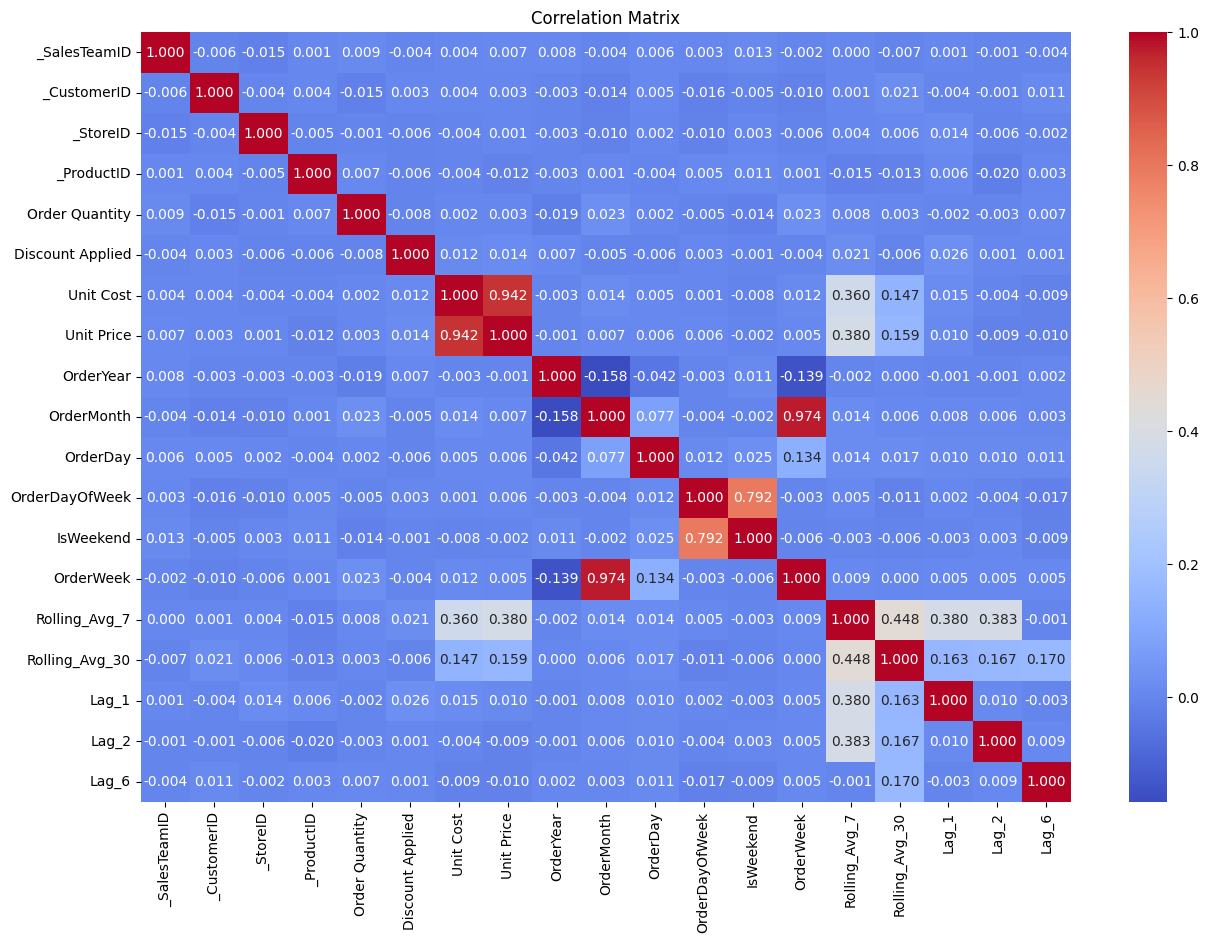

In [22]:
corr_matrix = data.select_dtypes(include='number').corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.3f', cbar=True)
plt.title('Correlation Matrix')
plt.show()

# encoding 

The code is used to convert categorical variables into dummy/indicator variables. Specifically, it takes the columns `'Sales Channel'` and `'WarehouseCode'` from the DataFrame `data` and creates binary columns for each unique value in these columns. This is helpful in machine learning models, as they often require numerical inputs instead of categorical ones.


In [23]:
data = pd.get_dummies(data, columns=['Sales Channel', 'WarehouseCode'])


This command resets the index of a DataFrame (`data`) to the default integer index (0, 1, 2, ...).  
- Useful when the current index is non-default (e.g., after grouping or setting a column as index) and you want to flatten the DataFrame.


In [24]:
data.reset_index(inplace=True)

The code removes specific columns from the DataFrame `data`. The list `columns_to_drop` contains the names of the columns to be dropped, including `'OrderNumber'`, `'_StoreID'`, `'_SalesTeamID'`, `'_CustomerID'`, `'CurrencyCode'`, `'ProcuredDate'`, `'ShipDate'`, `'DeliveryDate'`, and `'OrderDate'`. This is typically done to clean the dataset by removing unnecessary or irrelevant columns before analysis or model training.


In [25]:
columns_to_drop = [ 'OrderNumber','_StoreID' , '_SalesTeamID', '_CustomerID',
                    'CurrencyCode', 'ProcuredDate', 'ShipDate', 'DeliveryDate','OrderDate']
data = data.drop(columns=columns_to_drop)

# saving

In [26]:
data.to_csv("cleaned_dataset.csv")